### 필요한 모듈

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# colab version
buy2018_1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/buy2018_1.csv')
buy2018_1 = buy2018_1.drop(['Unnamed: 0'], axis=1)
buy2018_2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/buy2018_2.csv')
buy2018_2 = buy2018_2.drop(['Unnamed: 0'], axis=1)
buy2019_1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/buy2019_1.csv')
buy2019_1 = buy2019_1.drop(['Unnamed: 0'], axis=1)
buy2019_2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/buy2019_2.csv')
buy2019_2 = buy2019_2.drop(['Unnamed: 0'], axis=1)
sns2018_1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/sns2018_1.csv')
sns2018_1 = sns2018_1.drop(['Unnamed: 0'], axis=1)
sns2018_2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/sns2018_2.csv')
sns2018_2 = sns2018_2.drop(['Unnamed: 0'], axis=1)
sns2019_1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/sns2019_1.csv')
sns2019_1 = sns2019_1.drop(['Unnamed: 0'], axis=1)
sns2019_2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/sns2019_2.csv')
sns2019_2 = sns2019_2.drop(['Unnamed: 0'], axis=1)
Seoul2018 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/Seoul2018.csv',encoding='cp949')
Seoul2019 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/Seoul2019.csv',encoding='cp949')
dust2018 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/dust2018.csv',encoding='cp949')
dust2019 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/dust2019.csv',encoding='cp949')
alert = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/alert.csv')
test = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/data/test.csv')

In [4]:
test = test.iloc[0:4,1:]

### 2018,2019 데이터 합치기

In [5]:
buy2018_1.columns = ['date','sex','age','big_cat','sm_cat','qty']
buy2018_2.columns = ['date','sex','age','big_cat','sm_cat','qty']
buy2019_1.columns = ['date','sex','age','big_cat','sm_cat','qty']
buy2019_2.columns = ['date','sex','age','big_cat','sm_cat','qty']
buy20189 = pd.concat([buy2018_1,buy2018_2,buy2019_1,buy2019_2])

In [6]:
sns2018_1.columns = ['date','big_cat','sm_cat','cnt']
sns2018_2.columns = ['date','big_cat','sm_cat','cnt']
sns2019_1.columns = ['date','big_cat','sm_cat','cnt']
sns2019_2.columns = ['date','big_cat','sm_cat','cnt']
sns20189 = pd.concat([sns2018_1,sns2018_2,sns2019_1,sns2019_2])

월, 일 설정

In [7]:
month = ['01']*31+['02']*28+['03']*31+['04']*30+['05']*31+['06']*30+['07']*31+['08']*31+['09']*30+['10']*31+['11']*30+['12']*31
day = list(range(1,32))+list(range(1,29))+list(range(1,32))+list(range(1,31))+list(range(1,32))+list(range(1,31))+list(range(1,32))+list(range(1,32))+list(range(1,31))+list(range(1,32))+list(range(1,31))+list(range(1,32))
for i in range(365):
  if day[i]<10:
    day[i] = '0'+str(day[i])
  else :
    day[i] = str(day[i])

In [8]:
date = []
for i in range(365):
  date.append('2018'+'-'+month[i]+'-'+day[i])
for i in range(365):
  date.append('2019'+'-'+month[i]+'-'+day[i])
df_dust = pd.DataFrame(date)
df_dust.columns = ['날짜']

In [9]:
df_dust

,날짜
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
725,2019-12-27
726,2019-12-28
727,2019-12-29
728,2019-12-30


In [10]:
Seoul20189 = pd.concat([Seoul2018, Seoul2019],ignore_index=True)
dust20189 = pd.concat([dust2018, dust2019],ignore_index=True)
temp = Seoul20189.iloc[:,3]
temp_L = Seoul20189.iloc[:,4]
temp_H = Seoul20189.iloc[:,6]
rain = Seoul20189.iloc[:,13]
wind_max = Seoul20189.iloc[:,17]
wind = Seoul20189.iloc[:,20]
humid = Seoul20189.iloc[:,26]
humid = humid / 100

## 결측치 처리

날씨 데이터 (0으로 대체)

In [11]:
# 날씨 데이터 결측치 0으로
Seoul2018 = Seoul2018.fillna(0)
Seoul2019 = Seoul2019.fillna(0)

미세먼지 데이터 (전날의 데이터로 대체)

In [12]:
dust = []
cnt = 0
for i in range(730):
  j = i-cnt
  if (df_dust['날짜'].iloc[i]==dust20189['일시'].iloc[j]):
    dust.append(dust20189['일 미세먼지 농도(㎍/㎥)'].iloc[j])
  else :
    dust.append(np.nan)
    cnt+=1
df_dust['미세먼지'] = pd.Series(dust)
df_dust = df_dust.fillna(method='ffill')
dust = df_dust.iloc[:,1]

# 변수 생성

### 계절 변수 만들기

In [13]:
import datetime as dt
date = pd.to_datetime(Seoul20189.iloc[:, 2])
season = np.zeros(730)
season = pd.Series(season, name='계절')
for i in range(0, len(date)):
    if date.dt.month[i] == 12 or date.dt.month[i] == 1 or date.dt.month[i] == 2 :
        season[i] = '겨울'
    elif date.dt.month[i] == 3 or date.dt.month[i] == 4 or date.dt.month[i] == 5 :
        season[i] = '봄'
    elif date.dt.month[i] == 6 or date.dt.month[i] == 7 or date.dt.month[i] == 8 :
        season[i] = '여름'
    else: season[i] = '가을'     
season

0      겨울
1      겨울
2      겨울
3      겨울
4      겨울
       ..
725    겨울
726    겨울
727    겨울
728    겨울
729    겨울
Name: 계절, Length: 730, dtype: object

### 계절 --> One-hot Encoding

In [14]:
season_dummies = pd.get_dummies(season)
# season_dummies = pd.DataFrame(season_dummies, columns=['봄', '여름', '가을', '겨울'])
season_dummies

,가을,겨울,봄,여름
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
725,0,1,0,0
726,0,1,0,0
727,0,1,0,0
728,0,1,0,0


### 체감온도 / 불쾌지수

In [15]:
# 체감온도
sens_temp = 13.27 + 0.6215*temp - 13.947*(wind**0.16) + 0.486*temp*(wind**0.16)
sens_temp = pd.Series(sens_temp, name='체감온도')
# 불쾌지수
THI = (9/5)*temp - 0.55*(1 - humid)*((9/5)*temp - 26) + 32
print(sens_temp[180], THI[180])

26.380913845600006 74.323328


In [16]:
THI_cat = np.zeros(730)
THI_cat = pd.Series(season, name='불쾌지수')
for i in range(0, len(THI_cat)):
    if THI [i] < 68 :
        THI_cat[i] = 'THI낮음'
    elif THI [i] >= 68 and THI [i] < 75 :
        THI_cat[i] = 'THI보통'
    elif THI [i] >= 75 and THI [i] < 80 :
        THI_cat[i] = 'THI높음'
    else: THI_cat[i] = 'THI매우높음'     
THI_cat[180]

'THI보통'

In [17]:
THI_dummies = pd.get_dummies(THI_cat)
# season_dummies = pd.DataFrame(season_dummies, columns=['봄', '여름', '가을', '겨울'])
THI_dummies

,THI낮음,THI높음,THI매우높음,THI보통
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
725,1,0,0,0
726,1,0,0,0
727,1,0,0,0
728,1,0,0,0


### 예측하고픈 종속변수

In [18]:
# 구매데이터

food2018 = buy20189[buy20189['big_cat']=='식품']
grouped = food2018.groupby(['date','sm_cat'], as_index=False)
date_cate = grouped.sum()
food = date_cate[date_cate['sm_cat']=='도라지/더덕']['qty']
food = food.reset_index(drop=True)

In [ ]:
# 소셜데이터

food2018 = sns20189[sns20189['big_cat']=='식품']
grouped = food2018.groupby(['date','sm_cat'], as_index=False)
date_cate = grouped.sum()
food = date_cate[date_cate['sm_cat']=='게장류']['cnt']
food = food.reset_index(drop=True)

### 최종으로 합친 데이터

In [19]:
total = pd.concat([season_dummies, temp, temp_L, temp_H, rain, wind_max, wind, humid, dust, sens_temp, THI_dummies, food, alert.iloc[:,1:]], axis=1)
total = total.fillna(0)

In [20]:
total

,가을,겨울,봄,여름,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),미세먼지,체감온도,THI낮음,THI높음,THI매우높음,THI보통,qty,태풍 주의보,태풍 경보,폭염 주의보,폭염 경보,한파 주의보,한파 경보
0,0,1,0,0,-1.3,-5.1,3.8,0.0,3.8,1.4,0.391,38.0,-2.923119,1,0,0,0,23,0,0,0,0,1,0
1,0,1,0,0,-1.8,-4.3,1.8,0.0,4.9,1.8,0.420,32.0,-4.132080,1,0,0,0,29,0,0,0,0,1,0
2,0,1,0,0,-4.7,-7.1,-0.4,0.0,3.5,2.2,0.423,32.0,-8.064631,1,0,0,0,33,0,0,0,0,1,0
3,0,1,0,0,-4.7,-8.7,-0.7,0.0,3.5,1.4,0.430,40.0,-6.780015,1,0,0,0,24,0,0,0,0,0,0
4,0,1,0,0,-3.0,-5.6,1.6,0.0,3.6,1.7,0.484,46.0,-5.364518,1,0,0,0,22,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,0,0,-1.7,-4.6,2.6,0.0,4.3,2.1,0.454,37.0,-4.421813,1,0,0,0,48,0,0,0,0,0,0
726,0,1,0,0,1.1,-3.6,6.1,0.0,3.7,2.0,0.476,47.0,-1.031852,1,0,0,0,24,0,0,0,0,0,0
727,0,1,0,0,3.8,1.1,6.2,1.4,4.4,2.9,0.525,47.0,1.284200,1,0,0,0,36,0,0,0,0,0,0
728,0,1,0,0,2.7,-5.7,6.8,0.4,7.4,2.9,0.703,43.0,-0.033338,1,0,0,0,84,0,0,0,0,1,1


In [21]:
total.corr()

,가을,겨울,봄,여름,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),미세먼지,체감온도,THI낮음,THI높음,THI매우높음,THI보통,qty,태풍 주의보,태풍 경보,폭염 주의보,폭염 경보,한파 주의보,한파 경보
가을,1.000000,-0.329686,-0.334548,-0.334548,0.080814,0.079023,0.086869,-0.000049,-0.066984,-0.012164,0.113549,-0.213189,0.083832,0.096176,-0.142319,-0.123394,0.046896,0.282177,0.097255,0.112553,-0.187586,-0.138756,-0.099056,-0.086269
겨울,-0.329686,1.000000,-0.332099,-0.332099,-0.743724,-0.726450,-0.753623,-0.134663,0.045130,0.087859,-0.331912,0.313679,-0.740367,0.386771,-0.164899,-0.122490,-0.279903,0.140488,-0.096015,-0.090960,-0.196446,-0.137740,0.419525,0.261671
봄,-0.334548,-0.332099,1.000000,-0.336996,-0.017021,-0.049425,0.013011,-0.010627,0.164986,0.095072,-0.106222,0.243340,-0.019836,0.317679,-0.167331,-0.124297,-0.196119,-0.143870,-0.097431,-0.092302,-0.158259,-0.139771,-0.147214,-0.086901
여름,-0.334548,-0.332099,-0.336996,1.000000,0.674784,0.691826,0.648547,0.144354,-0.143045,-0.170168,0.322570,-0.342310,0.671260,-0.797449,0.472827,0.368837,0.427250,-0.276743,0.095843,0.070452,0.540174,0.414756,-0.170546,-0.086901
평균기온(°C),0.080814,-0.743724,-0.017021,0.674784,1.000000,0.989876,0.990516,0.155002,-0.163949,-0.211659,0.437886,-0.356228,0.998971,-0.760483,0.374527,0.349329,0.460188,-0.219980,0.168236,0.164223,0.436301,0.350873,-0.421357,-0.268569
최저기온(°C),0.079023,-0.726450,-0.049425,0.691826,0.989876,1.000000,0.965369,0.204952,-0.152203,-0.188330,0.505011,-0.375117,0.987893,-0.779746,0.392618,0.353910,0.468256,-0.221440,0.184880,0.172734,0.437481,0.357378,-0.415311,-0.258566
최고기온(°C),0.086869,-0.753623,0.013011,0.648547,0.990516,0.965369,1.000000,0.102002,-0.172443,-0.229623,0.363368,-0.330439,0.990350,-0.728421,0.343597,0.345300,0.445443,-0.219414,0.149334,0.148403,0.429251,0.339674,-0.422948,-0.272632
일강수량(mm),-0.000049,-0.134663,-0.010627,0.144354,0.155002,0.204952,0.102002,1.000000,0.044620,-0.055404,0.519296,-0.134040,0.154938,-0.178369,0.107629,-0.039684,0.157669,-0.040720,0.129000,0.076453,0.084669,0.041814,-0.064331,-0.038122
최대 풍속(m/s),-0.066984,0.045130,0.164986,-0.143045,-0.163949,-0.152203,-0.172443,0.044620,1.000000,0.789998,-0.104570,-0.023710,-0.193448,0.123443,-0.042526,-0.058708,-0.085975,0.077356,0.057247,0.061473,-0.061155,-0.065340,0.268140,0.177629
평균 풍속(m/s),-0.012164,0.087859,0.095072,-0.170168,-0.211659,-0.188330,-0.229623,-0.055404,0.789998,1.000000,-0.150982,-0.096303,-0.248626,0.143172,-0.034847,-0.091734,-0.097213,0.103659,0.068852,0.112668,-0.072544,-0.081045,0.314753,0.250492


### 설명변수 & 종속변수 나누기 + 표준화

In [22]:
# 구매 데이터
y_target = total['qty']
y_target = y_target/sum(y_target)*100 # 종속 변수는 전체 합에서 차지하는 비율
X_data = total.drop(['qty'], axis=1, inplace=False)
X_data = StandardScaler().fit_transform(X_data)

In [ ]:
# 소셜 데이터
y_target = total['cnt']
y_target = y_target/sum(y_target)*100 # 종속 변수는 전체 합에서 차지하는 비율
X_data = total.drop(['cnt'], axis=1, inplace=False)
X_data = StandardScaler().fit_transform(X_data)

## outlier 제거

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


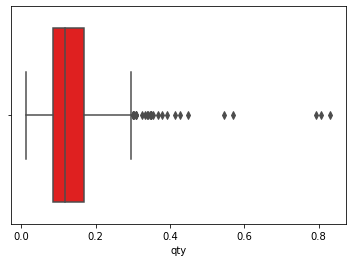

In [23]:
sns.boxplot(y_target,color='red')

In [ ]:
# outlier가 아닌 index를 도출하는 함수
def outliers_iqr(data):
  q1, q3 = np.percentile(data, [25,75])
  iqr = q3 - q1
  lower_bound = q1 - (iqr*1.5)
  upper_bound = q3 + (iqr*1.5)

  return np.where((data <= upper_bound) & (data >= lower_bound))

In [ ]:
y_target_not_outlier_index = outliers_iqr(y_target)
y_target_not_outlier_index = np.array(y_target_not_outlier_index)

In [ ]:
Y_target = []
X_data = pd.DataFrame(X_data)
new_X = pd.DataFrame(columns=range(X_data.shape[1]))
for i in y_target.index :
  if y_target.index[i] in y_target_not_outlier_index :
    Y_target.append(y_target[i])
    new_X = pd.concat([new_X,pd.DataFrame(X_data.iloc[i,:]).transpose()],axis=0)
y_target = Y_target
y_target = np.array(y_target)
X_data = new_X.reset_index(drop=True)

## 설명변수 간 상관관계 분석

In [ ]:
X_data = pd.DataFrame(X_data)
df = X_data.corr()

In [ ]:
sns.clustermap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]
vif["features"] = X_data.columns
vif

### 한글 폰트

In [ ]:
import platform
platform.system()

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

시간에 따른 구매량 추세

In [ ]:
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time_step, food1, label='참외/메론/수박')
ax.plot(time_step, food2, label='감귤/한라봉/오렌지')
ax.plot(time_step, food3, label='계란')

ax.set_title('판매량 추세')
ax.set_ylabel('판매량')
ax.set_xlabel('시간')
ax.legend()
plt.show()

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2,random_state=0)

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

### XGBOOST

In [ ]:
import xgboost as xgb

xgb = xgb.XGBRegressor()

#### KFold 5번

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
cv_mse = []
cv_r2 = []
cv_mape = []

In [ ]:
n_iter = 0
for train_idx, test_idx in kfold.split(X_data):
    X_train, X_test = X_data.iloc[train_idx,:], X_data.iloc[test_idx, :] 
    
    y_train, y_test = y_target[train_idx], y_target[test_idx]
    
    # 학습할 모델
    xgb.fit(X_train, y_train)
    # 예측
    pred = xgb.predict(X_test)
    
    # 정확도 측정
    n_iter += 1
    mse = np.round(mean_squared_error(y_test, pred), 4)
    r2 = np.round(r2_score(y_test, pred), 4)
    mape = np.round(MAPE(y_test, pred), 4)
    print('\n{} mse : {}, r2 : {}, mape : {}, 학습 데이터 크기 : {}, 검증 데이터 크기 : {}'.format(n_iter, mse, r2, mape, X_train.shape[0], X_test.shape[0]))
    
    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mape.append(mape)
print('\n')

print('\n 평균검증 r2: ', np.mean(cv_r2))
print('\n 평균검증 mse: ', np.mean(cv_mse))
print('\n 평균검증 mape: ', np.mean(cv_mape))

[12:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

1 mse : 0.0003, r2 : 0.2316, mape : 11.624, 학습 데이터 크기 : 536, 검증 데이터 크기 : 135
[12:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

2 mse : 0.0004, r2 : 0.1529, mape : 12.2054, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134
[12:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

3 mse : 0.0003, r2 : 0.2137, mape : 12.4879, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134
[12:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

4 mse : 0.0004, r2 : 0.2804, mape : 12.2485, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134
[12:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

5 mse : 0.0005, r2 : 0.0976, mape : 14.6318, 학습 데

Text(0.5, 1.0, 'Real value vs Predicted value: $Y_i$ vs $\\hat{Y}_i$')

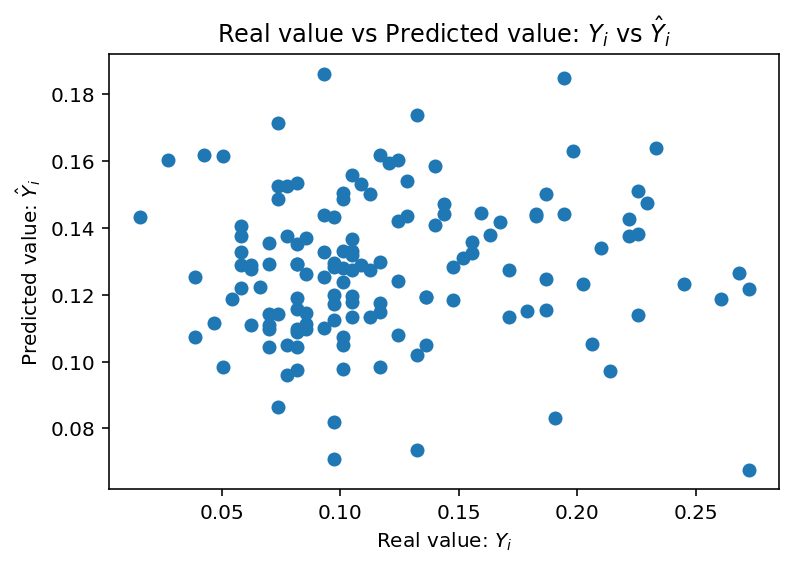

In [ ]:
plt.scatter(y_test, pred)
plt.xlabel("Real value: $Y_i$")
plt.ylabel("Predicted value: $\hat{Y}_i$")
plt.title("Real value vs Predicted value: $Y_i$ vs $\hat{Y}_i$")

In [ ]:
xgb.fit(x_train,y_train)
test.columns = range(0,23)
pred = xgb.predict(test)
pred

[10:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.07947478, 0.20737332, 0.32363755, 0.13440636], dtype=float32)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

rf = RandomForestRegressor(n_estimators=1000)

#### KFold 5번

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
cv_mse = []
cv_r2 = []
cv_mape = []

In [ ]:
n_iter = 0
for train_idx, test_idx in kfold.split(X_data):
    X_train, X_test = X_data.iloc[train_idx,:], X_data.iloc[test_idx, :] 
    
    y_train, y_test = y_target[train_idx], y_target[test_idx]
    
    # 학습할 모델
    rf.fit(X_train, y_train)
    # 예측
    pred = rf.predict(X_test)
    
    # 정확도 측정
    n_iter += 1
    mse = np.round(mean_squared_error(y_test, pred), 4)
    r2 = np.round(r2_score(y_test, pred), 4)
    mape = np.round(MAPE(y_test, pred), 4)
    print('\n{} mse : {}, r2 : {}, mape : {}, 학습 데이터 크기 : {}, 검증 데이터 크기 : {}'.format(n_iter, mse, r2, mape, X_train.shape[0], X_test.shape[0]))
    
    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mape.append(mape)
print('\n')

print('\n 평균검증 r2: ', np.mean(cv_r2))
print('\n 평균검증 mse: ', np.mean(cv_mse))
print('\n 평균검증 mape: ', np.mean(cv_mape))


1 mse : 0.0004, r2 : 0.1992, mape : 12.0678, 학습 데이터 크기 : 536, 검증 데이터 크기 : 135

2 mse : 0.0004, r2 : 0.189, mape : 11.8425, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

3 mse : 0.0003, r2 : 0.2065, mape : 12.3812, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

4 mse : 0.0004, r2 : 0.3173, mape : 11.9297, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

5 mse : 0.0005, r2 : 0.0301, mape : 15.1615, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134



 평균검증 mse:  0.0004

 평균검증 r2:  0.18842

 평균검증 mape:  12.67654


Text(0.5, 1.0, 'Real value vs Predicted value: $Y_i$ vs $\\hat{Y}_i$')

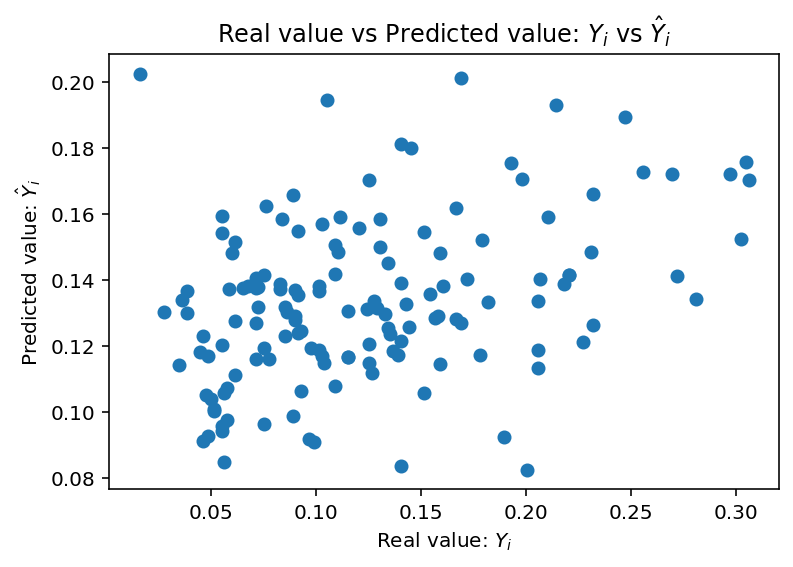

In [ ]:
plt.scatter(y_test, pred)
plt.xlabel("Real value: $Y_i$")
plt.ylabel("Predicted value: $\hat{Y}_i$")
plt.title("Real value vs Predicted value: $Y_i$ vs $\hat{Y}_i$")

In [ ]:
rf.fit(x_train, y_train)
pred = rf.predict(test)
pred

array([0.15054657, 0.07798506, 0.07389946, 0.08494914])

### LGBM Regressor

In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor()

#### KFold 5번

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
cv_mse = []
cv_r2 = []
cv_mape = []

In [ ]:
n_iter = 0
for train_idx, test_idx in kfold.split(X_data):
    X_train, X_test = X_data.iloc[train_idx,:], X_data.iloc[test_idx, :] 
    
    y_train, y_test = y_target[train_idx], y_target[test_idx]
    
    # 학습할 모델
    lgbm.fit(X_train, y_train)
    # 예측
    pred = lgbm.predict(X_test)
    
    # 정확도 측정
    n_iter += 1
    mse = np.round(mean_squared_error(y_test, pred), 4)
    r2 = np.round(r2_score(y_test, pred), 4)
    mape = np.round(MAPE(y_test, pred), 4)
    print('\n{} mse : {}, r2 : {}, mape : {}, 학습 데이터 크기 : {}, 검증 데이터 크기 : {}'.format(n_iter, mse, r2, mape, X_train.shape[0], X_test.shape[0]))
    
    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mape.append(mape)
print('\n')

print('\n 평균검증 r2: ', np.mean(cv_r2))
print('\n 평균검증 mse: ', np.mean(cv_mse))
print('\n 평균검증 mape: ', np.mean(cv_mape))


1 mse : 0.0004, r2 : 0.1107, mape : 12.6244, 학습 데이터 크기 : 536, 검증 데이터 크기 : 135

2 mse : 0.0004, r2 : 0.136, mape : 12.3483, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

3 mse : 0.0004, r2 : 0.1488, mape : 12.9494, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

4 mse : 0.0004, r2 : 0.2783, mape : 12.1796, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

5 mse : 0.0005, r2 : 0.0821, mape : 14.7459, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134



 평균검증 mse:  0.00042000000000000007

 평균검증 r2:  0.15118

 평균검증 mape:  12.96952


### 릿지 회귀

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10)

#### KFold 5번

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
cv_mse = []
cv_r2 = []
cv_mape = []

In [ ]:
n_iter = 0
for train_idx, test_idx in kfold.split(X_data):
    X_train, X_test = X_data.iloc[train_idx,:], X_data.iloc[test_idx, :] 
    
    y_train, y_test = y_target[train_idx], y_target[test_idx]
    
    # 학습할 모델
    ridge.fit(X_train, y_train)
    # 예측
    pred = ridge.predict(X_test)
    
    # 정확도 측정
    n_iter += 1
    mse = np.round(mean_squared_error(y_test, pred), 4)
    r2 = np.round(r2_score(y_test, pred), 4)
    mape = np.round(MAPE(y_test, pred), 4)
    print('\n{} mse : {}, r2 : {}, mape : {}, 학습 데이터 크기 : {}, 검증 데이터 크기 : {}'.format(n_iter, mse, r2, mape, X_train.shape[0], X_test.shape[0]))
    
    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mape.append(mape)
print('\n')

print('\n 평균검증 r2: ', np.mean(cv_r2))
print('\n 평균검증 mse: ', np.mean(cv_mse))
print('\n 평균검증 mape: ', np.mean(cv_mape))


1 mse : 0.0004, r2 : 0.1889, mape : 12.0236, 학습 데이터 크기 : 536, 검증 데이터 크기 : 135

2 mse : 0.0004, r2 : 0.1158, mape : 12.2408, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

3 mse : 0.0004, r2 : 0.1337, mape : 13.3983, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

4 mse : 0.0004, r2 : 0.201, mape : 12.8931, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134

5 mse : 0.0004, r2 : 0.1653, mape : 14.2538, 학습 데이터 크기 : 537, 검증 데이터 크기 : 134



 평균검증 mse:  0.0004

 평균검증 r2:  0.16094

 평균검증 mape:  12.961920000000001


In [ ]:
y_train.shape

(530,)

In [ ]:
ridge.fit(x_train, y_train)
pred = ridge.predict(test)
pred

array([ 0.37042885,  0.32795458, -0.53895385, -0.10191737])

### 중요 변수 산출

5     0.174083
6     0.166296
0     0.154829
12    0.077647
10    0.076097
2     0.074622
4     0.070017
11    0.063019
8     0.053929
9     0.038298
1     0.027948
7     0.015454
21    0.002709
19    0.001062
20    0.000665
3     0.000621
22    0.000619
16    0.000536
17    0.000459
13    0.000337
18    0.000288
14    0.000272
15    0.000193
dtype: float64


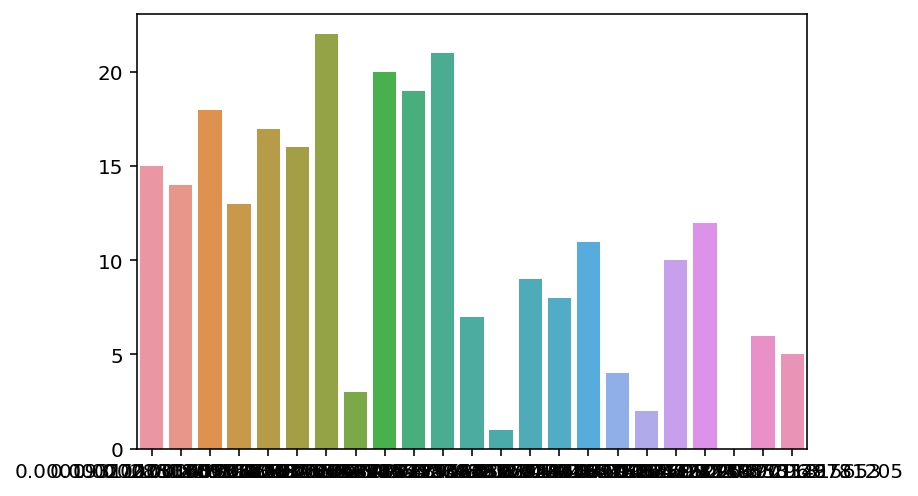

In [ ]:
import seaborn as sns
feature_series = pd.Series(data=rf.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
fig = plt.figure(figsize = (20,10))
sns.barplot(x = feature_series.index, y = feature_series)
print(feature_series)

## selecting 구매데이터



In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_livestock.csv')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fish.csv')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg1.csv')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg2.csv')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_kimchi.csv')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fruit.csv')

In [ ]:
result_rice

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,쌀,200,1.52,0.332,0.03,0.001,3.18,0.1,0.1,0.1,0.1


In [ ]:
result_livestock

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,계란,50,1.36,0.0341,0.1244,0.0737,5.54,0.128179,0.192897,0.189035,0.187736
1,돼지 곱창,100,2.50,0.0000,0.2652,0.1596,16.60,0.173928,0.098199,0.180658,0.178726
2,소고기 육회,100,1.12,0.0237,0.1395,0.0487,35.67,0.121110,0.147114,0.143016,0.149909


In [ ]:
result_fish

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,조개,85,0.76,0.0280,0.1410,0.0060,7.25,0.185258,0.108124,0.099891,0.150877
1,굴 생물,90,0.68,0.0391,0.0705,0.0246,18.00,0.169817,0.028839,0.028893,0.029940
2,장어,85,1.07,0.0000,0.1924,0.0293,53.72,-0.084061,0.154670,0.206394,0.107537
3,꽃게,100,1.01,0.0000,0.2003,0.0176,40.33,-0.260122,0.175550,0.568531,0.277177
4,대게/킹크랩,120,0.70,0.0003,0.1445,0.0086,69.92,0.888818,0.964793,0.283199,0.518814


In [ ]:
result_veg1

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,미나리,70,0.27,0.0670,0.0100,0.0020,17.500,0.370429,0.327955,-0.538954,-0.101917
1,오이/가지,100,0.14,0.0305,0.0122,0.0002,0.938,0.141809,0.203831,0.189559,0.128785
2,시금치,100,0.33,0.0600,0.0310,0.0050,8.500,0.179198,0.090312,0.086020,0.099325


In [ ]:
result_veg2

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,표고버섯,50,0.31,0.108,0.039,0.0040,18.57,0.167064,0.152314,0.108261,0.156593
1,도라지/더덕,50,0.56,0.130,0.017,0.0011,28.00,0.150547,0.077985,0.073899,0.084949
2,토마토,100,0.19,0.043,0.010,0.0020,3.15,0.127578,0.139547,0.086501,0.105609
3,감자,100,0.70,0.160,0.020,0.0003,3.00,0.124915,0.117374,0.098164,0.122577
4,옥수수,100,1.64,0.340,0.048,0.0160,16.60,0.092979,0.089213,0.184535,0.090236
5,고추/피망/파프리카,45,0.27,0.046,0.014,0.0080,15.80,0.161333,0.193483,0.115327,0.140143


In [ ]:
result_kimchi

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,배추김치,30,0.22,0.0416,0.0173,0.0032,6.61,0.028968,0.184568,0.609825,0.362655
1,무김치,30,0.30,0.0635,0.0129,0.0027,8.32,-0.090899,0.402270,0.871200,0.480393
2,물김치,30,0.20,0.0445,0.0112,0.0017,7.58,0.119477,0.392456,0.818874,0.459586


In [ ]:
result_fruit

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,포도/거봉/체리,100,0.67,0.1761,0.0083,0.0019,16.80,0.426712,0.813871,0.454498,0.482078
1,미숫가루/곡물가루,50,4.15,0.8000,0.1000,0.0600,10.00,0.127101,0.208000,0.226498,0.193195
2,딸기/복분자/블루베리,100,0.55,0.1257,0.0100,0.0080,42.00,0.241218,0.117907,0.116887,0.086758
3,감귤/한라봉/오렌지,100,0.50,0.1280,0.0100,0.0010,11.80,1.416313,0.973386,-0.263388,0.447830
4,바나나/파인애플/망고,100,0.84,0.2190,0.0110,0.0010,3.83,0.137823,0.157678,0.151188,0.143918
5,견과류 밤,50,1.51,0.3340,0.0330,0.0050,20.70,0.618773,0.486843,0.260381,0.397196
6,레몬/자몽,100,0.28,0.0930,0.0071,0.0008,6.95,0.047517,0.326221,0.388889,0.260059
7,참외/메론/수박,100,0.39,0.0940,0.0120,0.0018,7.90,0.079475,0.207373,0.323638,0.134406
8,키위/참다래,100,0.64,0.1480,0.0080,0.0100,11.27,0.104552,0.124291,0.119538,0.122077
9,감/홍시,100,0.58,0.1575,0.0040,0.0004,11.94,0.125146,0.131956,0.139542,0.100104


2020년 1월 15일

In [ ]:
result_rice = result_rice.iloc[:,0:8]
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = result_livestock.iloc[:,0:8]
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = result_fish.iloc[:,0:8]
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = result_veg1.iloc[:,0:8]
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = result_veg2.iloc[:,0:8]
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = result_kimchi.iloc[:,0:8]
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = result_fruit.iloc[:,0:8]
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
def calculate(result):
  result.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
  result = result.astype({'g': 'float','calorie':'float','carbo':'float','protein':'float','fat':'float','price':'float','pred':'float'})
  result['calorie'] = result['calorie'].mul(result['g'])
  result['carbo'] = result['carbo'].mul(result['g'])
  result['protein'] = result['protein'].mul(result['g'])
  result['fat'] = result['fat'].mul(result['g'])
  result['price'] = result['price'].mul(result['g'])
  return result

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
result_fruit

,item,g,calorie,carbo,protein,fat,price,pred
0,포도/거봉/체리,100.0,67.0,17.61,0.83,0.19,1680.0,0.426712
1,미숫가루/곡물가루,50.0,207.5,40.00,5.00,3.00,500.0,0.127101
2,딸기/복분자/블루베리,100.0,55.0,12.57,1.00,0.80,4200.0,0.241218
3,감귤/한라봉/오렌지,100.0,50.0,12.80,1.00,0.10,1180.0,1.416313
4,바나나/파인애플/망고,100.0,84.0,21.90,1.10,0.10,383.0,0.137823
5,견과류 밤,50.0,75.5,16.70,1.65,0.25,1035.0,0.618773
6,레몬/자몽,100.0,28.0,9.30,0.71,0.08,695.0,0.047517
7,참외/메론/수박,100.0,39.0,9.40,1.20,0.18,790.0,0.079475
8,키위/참다래,100.0,64.0,14.80,0.80,1.00,1127.0,0.104552
9,감/홍시,100.0,58.0,15.75,0.40,0.04,1194.0,0.125146


In [ ]:
calorie_lo = 530
calorie_up = 800
carbo_lo = 50
carbo_up = 120
protein_lo = 20
protein_up = 50
fat_lo = 5
fat_up = 20
price_lo = 0
price_up = 7000

In [ ]:
def selecting(rice,livestock,fish,veg1,veg2,kimchi,fruit):
  rice_num = rice.shape[0]
  livestock_num = livestock.shape[0]
  fish_num = fish.shape[0]
  veg1_num = veg1.shape[0]
  veg2_num = veg2.shape[0]
  kimchi_num = kimchi.shape[0]
  fruit_num = fruit.shape[0]
  result = np.zeros((100000,8))
  result = pd.DataFrame(result)
  result.columns = ['rice','livestock','fish','veg1','veg2','kimchi','fruit','pred']
  cnt = 0
  for a in range(rice_num):
    for b in range(livestock_num):
      for c in range(fish_num):
        for d in range(veg1_num):
          for e in range (veg2_num):
            for f in range (kimchi_num):
              for g in range (fruit_num):
                if ((float(rice.iloc[a,2]) + float(livestock.iloc[b,2]) + float(fish.iloc[c,2]) + float(veg1.iloc[d,2]) + float(veg2.iloc[e,2]) + float(kimchi.iloc[f,2]) + float(fruit.iloc[g,2]) >= calorie_lo) &
                (float(rice.iloc[a,2]) + float(livestock.iloc[b,2]) + float(fish.iloc[c,2]) + float(veg1.iloc[d,2]) + float(veg2.iloc[e,2]) + float(kimchi.iloc[f,2]) + float(fruit.iloc[g,2])  <= calorie_up) &
                (float(rice.iloc[a,3]) + float(livestock.iloc[b,3]) + float(fish.iloc[c,3]) + float(veg1.iloc[d,3]) + float(veg2.iloc[e,3]) + float(kimchi.iloc[f,3]) + float(fruit.iloc[g,3]) >= carbo_lo) &
                (float(rice.iloc[a,3]) + float(livestock.iloc[b,3]) + float(fish.iloc[c,3]) + float(veg1.iloc[d,3]) + float(veg2.iloc[e,3]) + float(kimchi.iloc[f,3]) + float(fruit.iloc[g,3]) <= carbo_up) &
                (float(rice.iloc[a,4]) + float(livestock.iloc[b,4]) + float(fish.iloc[c,4]) + float(veg1.iloc[d,4]) + float(veg2.iloc[e,4]) + float(kimchi.iloc[f,4]) + float(fruit.iloc[g,4]) >= protein_lo) &
                (float(rice.iloc[a,4]) + float(livestock.iloc[b,4]) + float(fish.iloc[c,4]) + float(veg1.iloc[d,4]) + float(veg2.iloc[e,4]) + float(kimchi.iloc[f,4]) + float(fruit.iloc[g,4]) <= protein_up) &
                (float(rice.iloc[a,5]) + float(livestock.iloc[b,5]) + float(fish.iloc[c,5]) + float(veg1.iloc[d,5]) + float(veg2.iloc[e,5]) + float(kimchi.iloc[f,5]) + float(fruit.iloc[g,5]) >= fat_lo) &
                (float(rice.iloc[a,5]) + float(livestock.iloc[b,5]) + float(fish.iloc[c,5]) + float(veg1.iloc[d,5]) + float(veg2.iloc[e,5]) + float(kimchi.iloc[f,5]) + float(fruit.iloc[g,5]) <= fat_up) &
                (float(rice.iloc[a,6]) + float(livestock.iloc[b,6]) + float(fish.iloc[c,6]) + float(veg1.iloc[d,6]) + float(veg2.iloc[e,6]) + float(kimchi.iloc[f,6]) + float(fruit.iloc[g,6]) >= price_lo) &
                (float(rice.iloc[a,6]) + float(livestock.iloc[b,6]) + float(fish.iloc[c,6]) + float(veg1.iloc[d,6]) + float(veg2.iloc[e,6]) + float(kimchi.iloc[f,6]) + float(fruit.iloc[g,6]) <= price_up)) :
                  result.iloc[cnt,0] = rice.iloc[a,0]
                  result.iloc[cnt,1] = livestock.iloc[b,0]
                  result.iloc[cnt,2] = fish.iloc[c,0]
                  result.iloc[cnt,3] = veg1.iloc[d,0]
                  result.iloc[cnt,4] = veg2.iloc[e,0]
                  result.iloc[cnt,5] = kimchi.iloc[f,0]
                  result.iloc[cnt,6] = fruit.iloc[g,0]
                  result.iloc[cnt,7] = float(rice.iloc[a,7]) + float(livestock.iloc[b,7]) + float(fish.iloc[c,7]) + float(veg1.iloc[d,7]) + float(veg2.iloc[e,7]) + float(kimchi.iloc[f,7]) + float(fruit.iloc[g,7])
                  result = result.astype({'pred':'float'})
                  cnt += 1
  result = result.sort_values(by='pred',ascending=False)
  final = result.iloc[0:5,:]
  return final

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
587,쌀,돼지 곱창,조개,미나리,표고버섯,물김치,감귤/한라봉/오렌지,2.532469
679,쌀,돼지 곱창,조개,미나리,고추/피망/파프리카,물김치,감귤/한라봉/오렌지,2.526738
608,쌀,돼지 곱창,조개,미나리,도라지/더덕,물김치,감귤/한라봉/오렌지,2.515951
632,쌀,돼지 곱창,조개,미나리,토마토,물김치,감귤/한라봉/오렌지,2.492982
655,쌀,돼지 곱창,조개,미나리,감자,물김치,감귤/한라봉/오렌지,2.490320


2020년 4월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_livestock.csv')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fish.csv')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg1.csv')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg2.csv')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_kimchi.csv')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fruit.csv')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,8]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,8]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,8]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,8]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,8]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,8]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,8]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
671,쌀,돼지 곱창,조개,미나리,고추/피망/파프리카,무김치,감귤/한라봉/오렌지,2.203417
679,쌀,돼지 곱창,조개,미나리,고추/피망/파프리카,물김치,감귤/한라봉/오렌지,2.193603
512,쌀,계란,꽃게,오이/가지,토마토,무김치,감귤/한라봉/오렌지,2.187481
520,쌀,계란,꽃게,오이/가지,토마토,물김치,감귤/한라봉/오렌지,2.177667
534,쌀,계란,꽃게,오이/가지,감자,무김치,감귤/한라봉/오렌지,2.165308


2020년 7월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_livestock.csv')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fish.csv')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg1.csv')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg2.csv')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_kimchi.csv')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fruit.csv')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,9]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,9]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,9]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,9]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,9]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,9]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,9]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
555,쌀,계란,꽃게,오이/가지,고추/피망/파프리카,무김치,레몬/자몽,2.422541
498,쌀,계란,꽃게,오이/가지,표고버섯,무김치,레몬/자몽,2.415475
537,쌀,계란,꽃게,오이/가지,감자,무김치,레몬/자몽,2.405378
515,쌀,계란,꽃게,오이/가지,토마토,무김치,레몬/자몽,2.393716
559,쌀,계란,꽃게,오이/가지,고추/피망/파프리카,물김치,레몬/자몽,2.370215


2020년 10월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_livestock.csv')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fish.csv')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg1.csv')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_veg2.csv')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_kimchi.csv')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result_fruit.csv')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,10]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,10]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,10]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,10]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,10]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,10]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,10]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
534,쌀,계란,꽃게,오이/가지,감자,무김치,감귤/한라봉/오렌지,1.744499
512,쌀,계란,꽃게,오이/가지,토마토,무김치,감귤/한라봉/오렌지,1.727530
541,쌀,계란,꽃게,오이/가지,감자,물김치,감귤/한라봉/오렌지,1.723692
520,쌀,계란,꽃게,오이/가지,토마토,물김치,감귤/한라봉/오렌지,1.706723
536,쌀,계란,꽃게,오이/가지,감자,무김치,견과류 밤,1.693865


##selecting 소셜 데이터


In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_livestock.csv',encoding='cp949')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fish.csv',encoding='cp949')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg1.csv',encoding='cp949')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg2.csv',encoding='cp949')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_kimchi.csv',encoding='cp949')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fruit.csv',encoding='cp949')

In [ ]:
result_rice

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,쌀,200,1.52,0.332,0.03,0.001,3.18,0.1,0.1,0.1,0.1


In [ ]:
result_livestock

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,닭가슴살,100,1.07,0.0000,0.2300,0.0010,13.29,0.132047,0.182037,0.186008,0.158173
1,한우육,100,2.98,0.0190,0.1650,0.2440,204.50,0.164720,0.138830,0.148510,0.163508
2,오리고기/훈제오리,100,1.17,0.0000,0.2100,0.0300,17.97,0.036108,0.206135,0.124916,0.106319
3,갈비/찜/바비큐용 돈육,100,3.95,0.0000,0.2894,0.3017,36.50,-0.319085,-0.112979,0.170822,0.004977
4,윙봉/닭다리/날개,100,2.21,0.0041,0.2679,0.1169,16.05,0.121871,0.138327,0.142415,0.132722


In [ ]:
result_fish

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,전복 생물,70,0.90,0.0510,0.1500,0.0070,48.78,0.129188,0.158283,0.161498,0.161129
1,오징어,57,0.92,0.0308,0.1558,0.0138,16.99,0.132591,0.155089,0.154925,0.155164
2,고등어,85,1.67,0.0000,0.1932,0.0936,12.49,0.148885,0.150110,0.155482,0.163926
3,주꾸미,120,0.47,0.0126,0.0852,0.0059,23.30,0.095894,0.108480,0.070642,0.165341
4,조개,85,0.76,0.0280,0.1410,0.0060,7.25,0.130905,0.153812,0.164036,0.151927
5,새우/대하,85,1.06,0.0091,0.2031,0.0173,27.97,0.132696,0.142787,0.143803,0.160257
6,명태/동태,90,0.76,0.0000,0.1659,0.0063,7.93,0.154223,0.120317,0.116145,0.134779
7,문어,80,0.82,0.0220,0.1491,0.0104,34.50,0.128252,0.163821,0.166747,0.164138
8,갈치,80,1.43,0.0000,0.1873,0.0701,22.56,0.127772,0.164179,0.166989,0.164274
9,굴 생물,90,0.68,0.0391,0.0705,0.0246,18.00,0.194883,0.079863,0.079854,0.080170


In [ ]:
result_veg1

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,쌈채소,100,0.27,0.0410,0.0350,0.0040,13.24,0.132314,0.134267,0.132311,0.133514
1,파/양파,50,0.30,0.0670,0.0120,0.0020,1.32,0.138404,0.149770,0.150980,0.138530
2,양배추/양상추,50,0.33,0.0792,0.0168,0.0008,7.88,0.137371,0.157641,0.146209,0.123264
3,미나리,70,0.27,0.0670,0.0100,0.0020,17.50,0.135096,0.161148,0.098704,0.098266
4,브로콜리/셀러리,100,0.32,0.0632,0.0308,0.0020,11.00,0.148326,0.121717,0.113180,0.114766
5,시금치,100,0.33,0.0600,0.0310,0.0050,8.50,0.428950,0.231048,-0.346939,-0.012311
6,부추,100,0.22,0.0410,0.0180,0.0030,5.87,0.117024,0.168855,0.168390,0.167927


In [ ]:
result_veg2

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,표고버섯,50,0.31,0.1080,0.0390,0.0040,18.57,0.124760,0.134229,0.119395,0.144731
1,도라지/더덕,50,0.56,0.1300,0.0170,0.0011,28.00,0.033060,0.218516,0.373096,0.233937
2,우엉/연근,100,0.69,0.1530,0.0260,0.0006,11.86,0.150534,0.012987,-0.174084,-0.018068
3,토마토,100,0.19,0.0430,0.0100,0.0020,3.15,0.126276,0.165537,0.149642,0.126343
4,감자,100,0.70,0.1600,0.0200,0.0003,3.00,0.125132,0.130874,0.155030,0.131248
5,옥수수,100,1.64,0.3400,0.0480,0.0160,16.60,0.109564,0.130138,0.177949,0.131299
6,호박,100,0.38,0.0850,0.0090,0.0020,7.49,0.115885,0.141692,0.144648,0.154117
7,마늘/생강,20,1.23,0.2642,0.0745,0.0016,9.45,0.136881,0.132540,0.126354,0.131577
8,고추/피망/파프리카,45,0.27,0.0460,0.0140,0.0080,15.80,0.131450,0.132366,0.140759,0.134834


In [ ]:
result_kimchi

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,젓갈류,30,1.28,0.1281,0.1174,0.0300,15.10,0.130975,0.136289,0.136567,0.123924
1,무김치,30,0.30,0.0635,0.0129,0.0027,8.32,0.155258,0.166408,0.132955,0.133985
2,물김치,30,0.20,0.0445,0.0112,0.0017,7.58,0.155774,0.172537,0.167988,0.143596
3,파김치,30,0.38,0.0824,0.0201,0.0031,9.80,0.123982,0.162629,0.093117,0.159566


In [ ]:
result_fruit

,item,g,calorie,carbo,protein,fat,price,pred1,pred2,pred3,pred4
0,포도/거봉/체리,100,0.67,0.1761,0.0083,0.0019,16.80,0.112691,0.136948,0.166813,0.178377
1,미숫가루/곡물가루,50,4.15,0.8000,0.1000,0.0600,10.00,0.108416,0.214852,0.214075,0.215105
2,견과류 호두,20,6.88,0.0700,0.1550,0.7199,13.20,0.136192,0.126098,0.115369,0.139469
3,딸기/복분자/블루베리,100,0.55,0.1257,0.0100,0.0080,42.00,0.170853,0.135265,0.098110,0.080592
4,감귤/한라봉/오렌지,100,0.50,0.1280,0.0100,0.0010,11.80,0.154215,0.130752,0.105990,0.107275
5,바나나/파인애플/망고,100,0.84,0.2190,0.0110,0.0010,3.83,0.125138,0.151829,0.148085,0.126960
6,참외/메론/수박,100,0.39,0.0940,0.0120,0.0018,7.90,0.074717,0.197835,0.303753,0.114353
7,키위/참다래,100,0.64,0.1480,0.0080,0.0100,11.27,0.130875,0.144404,0.150869,0.139160
8,견과류 마카다미아,20,7.20,0.1220,0.0830,0.7670,38.50,0.148354,0.104170,0.104538,0.180990
9,감/홍시,100,0.58,0.1575,0.0040,0.0004,11.94,0.129073,0.120915,0.121023,0.142583


2020년 1월 15일

In [ ]:
result_rice = result_rice.iloc[:,0:8]
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = result_livestock.iloc[:,0:8]
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = result_fish.iloc[:,0:8]
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = result_veg1.iloc[:,0:8]
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = result_veg2.iloc[:,0:8]
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = result_kimchi.iloc[:,0:8]
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = result_fruit.iloc[:,0:8]
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
2889,쌀,닭가슴살,굴 생물,시금치,우엉/연근,물김치,견과류 마카다미아,1.310543
2887,쌀,닭가슴살,굴 생물,시금치,우엉/연근,무김치,견과류 마카다미아,1.310027
2888,쌀,닭가슴살,굴 생물,시금치,우엉/연근,물김치,견과류 호두,1.298380
2886,쌀,닭가슴살,굴 생물,시금치,우엉/연근,무김치,견과류 호두,1.297864
2923,쌀,닭가슴살,굴 생물,시금치,마늘/생강,물김치,견과류 마카다미아,1.296890


2020년 4월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_livestock.csv',encoding='cp949')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fish.csv',encoding='cp949')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg1.csv',encoding='cp949')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg2.csv',encoding='cp949')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_kimchi.csv',encoding='cp949')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fruit.csv',encoding='cp949')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,8]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,8]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,8]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,8]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,8]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,8]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,8]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
4490,쌀,오리고기/훈제오리,고등어,시금치,도라지/더덕,물김치,참외/메론/수박,1.276180
4488,쌀,오리고기/훈제오리,고등어,시금치,도라지/더덕,무김치,참외/메론/수박,1.270051
4492,쌀,오리고기/훈제오리,고등어,시금치,도라지/더덕,파김치,참외/메론/수박,1.266271
3669,쌀,오리고기/훈제오리,오징어,시금치,토마토,물김치,미숫가루/곡물가루,1.245197
7036,쌀,오리고기/훈제오리,갈치,부추,도라지/더덕,물김치,미숫가루/곡물가루,1.245074


2020년 7월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_livestock.csv',encoding='cp949')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fish.csv',encoding='cp949')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg1.csv',encoding='cp949')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg2.csv',encoding='cp949')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_kimchi.csv',encoding='cp949')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fruit.csv',encoding='cp949')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,9]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,9]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,9]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,9]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,9]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,9]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,9]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
2443,쌀,닭가슴살,갈치,부추,도라지/더덕,물김치,참외/메론/수박,1.466224
932,쌀,닭가슴살,고등어,부추,도라지/더덕,물김치,참외/메론/수박,1.454718
1978,쌀,닭가슴살,갈치,파/양파,도라지/더덕,물김치,참외/메론/수박,1.448813
2129,쌀,닭가슴살,갈치,양배추/양상추,도라지/더덕,물김치,참외/메론/수박,1.444043
566,쌀,닭가슴살,고등어,파/양파,도라지/더덕,물김치,참외/메론/수박,1.437307


2020년 10월 15일

In [ ]:
result_rice = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_rice.csv')
result_livestock = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_livestock.csv',encoding='cp949')
result_fish = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fish.csv',encoding='cp949')
result_veg1 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg1.csv',encoding='cp949')
result_veg2 = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_veg2.csv',encoding='cp949')
result_kimchi = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_kimchi.csv',encoding='cp949')
result_fruit = pd.read_csv('/gdrive/My Drive/weather_bigdata_contest/result/result2_fruit.csv',encoding='cp949')

In [ ]:
result_rice = pd.concat([result_rice.iloc[:,0:7],result_rice.iloc[:,10]],axis=1)
result_rice.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_livestock = pd.concat([result_livestock.iloc[:,0:7],result_livestock.iloc[:,10]],axis=1)
result_livestock.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fish = pd.concat([result_fish.iloc[:,0:7],result_fish.iloc[:,10]],axis=1)
result_fish.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg1 = pd.concat([result_veg1.iloc[:,0:7],result_veg1.iloc[:,10]],axis=1)
result_veg1.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_veg2 = pd.concat([result_veg2.iloc[:,0:7],result_veg2.iloc[:,10]],axis=1)
result_veg2.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_kimchi = pd.concat([result_kimchi.iloc[:,0:7],result_kimchi.iloc[:,10]],axis=1)
result_kimchi.columns = ['item','g','calorie','carbo','protein','fat','price','pred']
result_fruit = pd.concat([result_fruit.iloc[:,0:7],result_fruit.iloc[:,10]],axis=1)
result_fruit.columns = ['item','g','calorie','carbo','protein','fat','price','pred']

In [ ]:
result_rice = calculate(result_rice)
result_livestock = calculate(result_livestock)
result_fish = calculate(result_fish)
result_veg1 = calculate(result_veg1)
result_veg2 = calculate(result_veg2)
result_kimchi = calculate(result_kimchi)
result_fruit = calculate(result_fruit)

In [ ]:
selecting(result_rice,result_livestock,result_fish,result_veg1,result_veg2,result_kimchi,result_fruit)

,rice,livestock,fish,veg1,veg2,kimchi,fruit,pred
935,쌀,닭가슴살,고등어,부추,도라지/더덕,파김치,포도/거봉/체리,1.161905
485,쌀,닭가슴살,오징어,부추,도라지/더덕,파김치,견과류 마카다미아,1.155758
1529,쌀,닭가슴살,조개,부추,도라지/더덕,파김치,견과류 마카다미아,1.152520
929,쌀,닭가슴살,고등어,부추,도라지/더덕,물김치,포도/거봉/체리,1.145935
483,쌀,닭가슴살,오징어,부추,도라지/더덕,물김치,견과류 마카다미아,1.139787
